Parameters of the Largest Circle:
Center: (1342, 641)
Radius: 40
Range of Sigma Values Used: 10.0 to 40.0


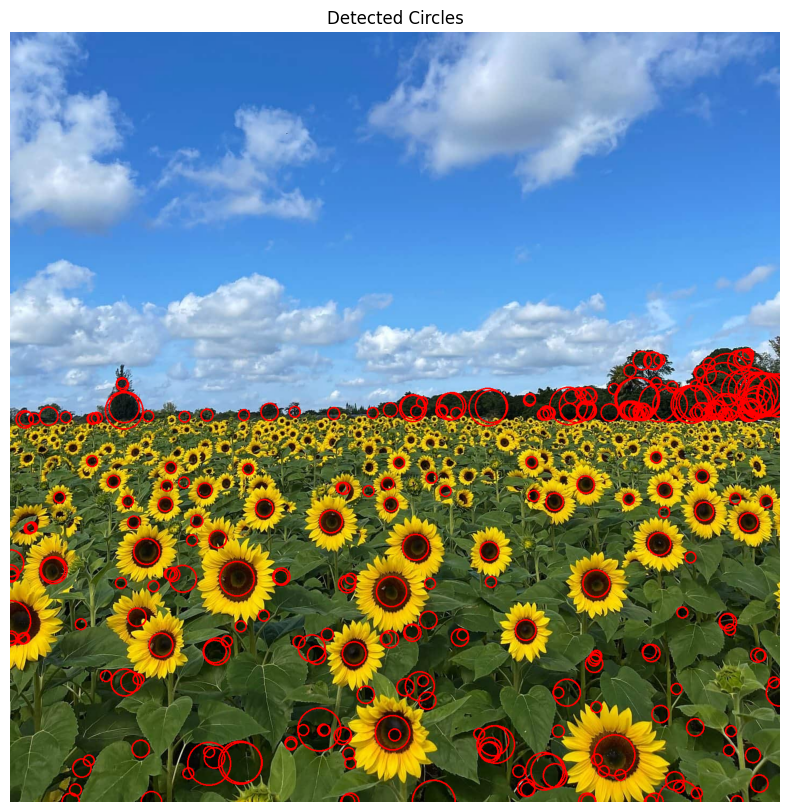

In [51]:
import cv2 as cv
import numpy as np
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_COLOR)

# Convert the image to grayscale
gray_im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Define a range of sigma values
sigma_values = np.linspace(10, 40, 20)

# Initialize an array to store the scale space
scale_space = []

for sigma in sigma_values:
    # Calculate the LoG kernel for the current sigma
    kernel_size = int(4 * sigma) + 1
    kernel_hw = kernel_size // 2
    X, Y = np.meshgrid(np.arange(-kernel_hw, kernel_hw + 1), np.arange(-kernel_hw, kernel_hw + 1))
    log_kernel = (X ** 2 + Y ** 2 - 2 * sigma ** 2) * np.exp(-(X ** 2 + Y ** 2) / (2 * sigma ** 2))

    # Apply LoG filtering to the grayscale image
    log_response = cv.filter2D(gray_im.astype(np.float32), -1, log_kernel)

    # Store the result in the scale space
    scale_space.append(log_response)

# Convert the scale space to a numpy array
scale_space = np.array(scale_space)

# Find local maxima in the scale space using a maximum filter
local_maxima = maximum_filter(scale_space, size=(3, 3, 3))

# Identify the coordinates of the local maxima
maxima_coordinates = np.argwhere((scale_space == local_maxima) & (local_maxima > 0))

detected_circles = []

for coord in maxima_coordinates:
    z, y, x = coord
    radius = int(1 * sigma_values[z])  # Adjust the scale factor as needed
    center = (x, y)
    detected_circles.append((center, radius))

largest_circle = max(detected_circles, key=lambda x: x[1])
largest_center, largest_radius = largest_circle
print("Parameters of the Largest Circle:")
print("Center:", largest_center)
print("Radius:", largest_radius)
print("Range of Sigma Values Used:", sigma_values[0], "to", sigma_values[-1])

# Draw detected circles on the original image
output_image = im.copy()
for circle in detected_circles:
    center, radius = circle
    cv.circle(output_image, center, radius, (0, 0, 255), 2)  # Draw circles in red

# Convert BGR image to RGB for Matplotlib
output_image_rgb = cv.cvtColor(output_image, cv.COLOR_BGR2RGB)

# Display the image with detected circles using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.title("Detected Circles")
plt.axis('off')
plt.show()


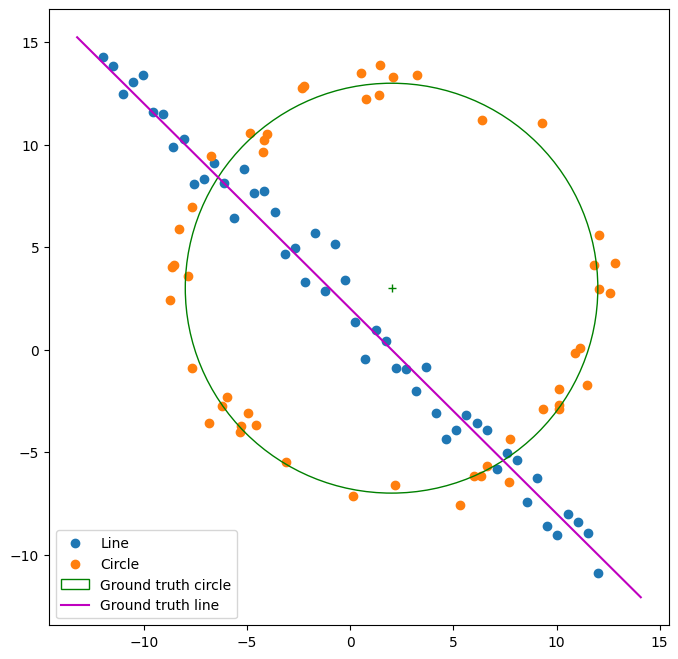

In [52]:
# Generation of a Noisy Point Set Conforming to a Line and a Circle
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.234677716095221e-10
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 7
rex.x:  [0.67068084 0.74174606 1.3999057 ]
Iteration =  0 . No. inliners =  34
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.104764998663757e-08
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
rex.x:  [0.99770819 0.06766428 9.96263834]
Iteration =  1 . No. inliners =  10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.860536375980414e-10
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 11
rex.x:  [  0.72578664  -0.68791988 -10.08248101]
Iteration =  2 . No. inliners =  13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.057796351508164e-11
        

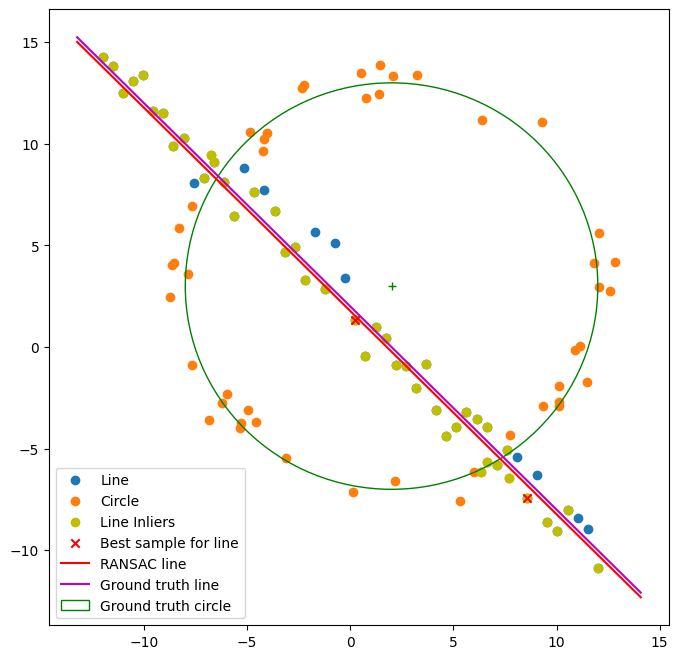

In [53]:
import math
N=X.shape[0]
X_=X
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X_, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indinces of the inliers
max_iterations = 200
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Line Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], marker='x', color='r', label='Best sample for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_est, color='r', label='RANSAC line')
plt.plot(x_, y_, color='m', label='Ground truth line')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
plt.legend()
plt.show()



Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.677328035005644e-05
            Iterations: 25
            Function evaluations: 135
            Gradient evaluations: 25
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.878011859053231e-06
            Iterations: 27
            Function evaluations: 146
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.600573170343461
            Iterations: 14
            Function evaluations: 93
            Gradient evaluations: 14
[44  4  1]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.8621436925769785e-06
            Iterations: 48
            Function evaluations: 293
            Gradient evaluations: 48
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0903093382808038e-05
            Iterations:

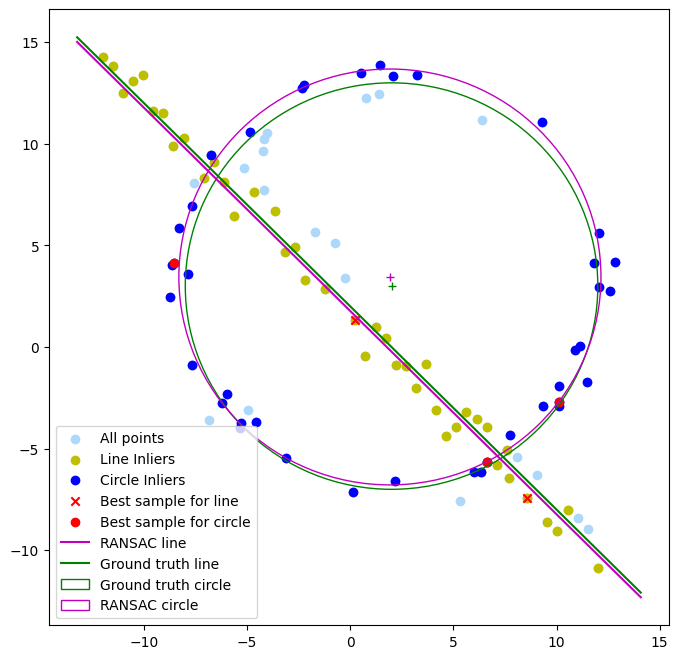

In [56]:
remaining_points=X
if best_inliers_line is not None:
    remaining_points= remaining_points[best_inliers_line, :]

def circle_consensus(data, model,t):
    center_x, center_y, radius = model
    distances = np.sqrt((data[:, 0] - center_x)**2 + (data[:, 1] - center_y)**2)
    inliers = np.abs(distances - radius) < t
    return inliers

def circle_tls(x, indices, remaining_points):
    x_center, y_center, r = x[0], x[1], x[2]
    # Calculate the squared differences between the distances and the circle's radius
    squared_errors = np.sqrt((remaining_points[indices, 0] - x_center)**2 + (remaining_points[indices, 1] - y_center)**2 )
    # Return the sum of squared errors
    return np.sum(np.abs(squared_errors-r))

distance_treshold=0.8
con_c={'type': 'ineq', 'fun': lambda x: x[2] - distance_treshold}

def ransac_circle(X, t, iter, in_t):
    n = X.shape[0]
    best_error = np.inf
    best_sample_circle = []  
    res_only_with_sample = [] 
    best_inliers_circle = []   

    for i in range(iter):
        indices = np.random.choice(n, 3, replace=False)
        x0 = [1, 1, 1]
        res = minimize(fun=circle_tls, args=(indices,X), x0=x0, tol=1e-6, constraints=con_c, options={'disp': True})
        inliers = circle_consensus(X, res.x, t)
        n_inliers = np.sum(inliers)
        if n_inliers > in_t:
            x0 = res.x
            res = minimize(fun=circle_tls, args=(inliers,X), x0=x0, tol=1e-6, constraints=con_c, options={'disp': True})
            if res.fun < best_error:
                best_error = res.fun
                best_inliers_circle = inliers
                best_x_center, best_y_center, best_r = res.x
                best_sample_circle = indices
                print(indices)
                res_only_with_sample = x0

    return best_x_center, best_y_center, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample

best_x_center, best_y_center, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample = ransac_circle(X_circ, distance_treshold, 200, 0.9 * remaining_points.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
light_blue = (173/255, 216/255, 250/255)
ax.scatter(X[:, 0], X[:, 1], color=light_blue, label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Line Inliers')
ax.scatter(X_circ[best_inliers_circle, 0], X_circ[best_inliers_circle, 1], color='b', label='Circle Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], marker='x', color='r', label='Best sample for line')
ax.scatter(X_circ[best_sample_circle, 0], X_circ[best_sample_circle, 1], color='r', label='Best sample for circle')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_est, color='m', label='RANSAC line')
plt.plot(x_, y_, color='g', label='Ground truth line')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
# Estimated circle
circle_est = plt.Circle((best_x_center, best_y_center), best_r, color='m', fill=False, label='RANSAC circle')
ax.add_patch(circle_est)
ax.plot(best_x_center, best_y_center, '+', color='m')
plt.legend()
plt.show()



In [55]:
print(best_x_center, best_y_center, best_r)

1.8937385705040903 3.454020081677348 10.258734691667875
